<a href="https://colab.research.google.com/github/AzeemWaqarRao/Pytorch_Implementations/blob/main/LSTMusingPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('AMZN.csv')

In [ ]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [ ]:
data = data[['Date','Close']]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6511,2023-03-30,102.000000
6512,2023-03-31,103.290001
6513,2023-04-03,102.410004
6514,2023-04-04,103.949997


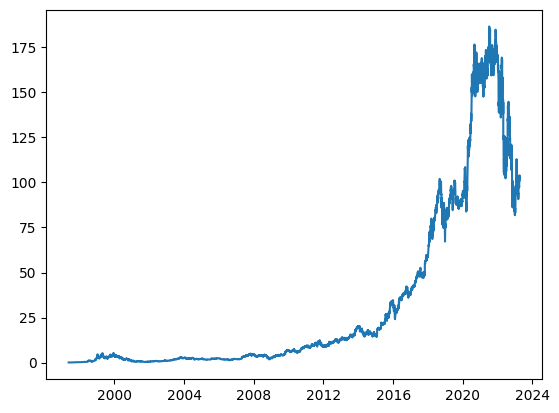

In [ ]:
plt.plot(data['Date'], data['Close'])

In [ ]:
# prepare dataset
# we will create features for each data point where we will
# look back n number of days

from copy import deepcopy


lookback = 7
shifted_data = data

for i in range(1,lookback+1):
  shifted_data[f'Close (t-{i})'] = shifted_data['Close'].shift(i)

shifted_data.set_index('Date',inplace=True)
shifted_data.dropna(inplace=True)

In [ ]:
shifted_data

,Close,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6),Close (t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [ ]:
# Scaling Data
scaler = MinMaxScaler(feature_range = (-1,1))

shifted_data = scaler.fit_transform(shifted_data)
shifted_data


array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [ ]:
shifted_data.shape

(6509, 8)

In [ ]:
X = shifted_data[:,1:]
y = shifted_data[:,0]

In [ ]:
X = np.flip(X,axis=1)
# since we need t-7 to t-1 data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,shuffle=False)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4361, 7), (2148, 7), (4361,), (2148,))

In [ ]:
X_train = X_train.reshape(-1,lookback,1)
X_test = X_test.reshape(-1,lookback,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
# as pytorch requires data in column format

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4361, 7, 1), (2148, 7, 1), (4361, 1), (2148, 1))

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# creating dataset for pytorch

class stock_data(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i], self.y[i]


In [ ]:
train_data = stock_data(X_train, y_train)
test_data = stock_data(X_test, y_test)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_data,batch_size)
test_loader = DataLoader(test_data, batch_size)

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, num_hidden, num_stack):
    super().__init__()
    self.num_hidden = num_hidden
    self.num_stack = num_stack
    self.lstm = nn.LSTM(input_size,self.num_hidden,self.num_stack,
                        batch_first = True)
    self.fc = nn.Linear(num_hidden,1)

  def forward(self,x):
    batch_size = x.shape[0]
    h0 = torch.zeros(self.num_stack, batch_size, self.num_hidden)
    c0 = torch.zeros(self.num_stack, batch_size, self.num_hidden)
    out, _ = self.lstm(x,(h0,c0))
    out = self.fc(out[:,-1,:])
    return out


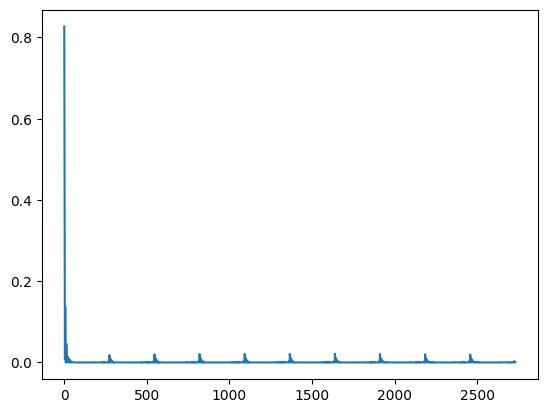

In [ ]:
lstm = LSTM(1, 32, 1)
learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(),lr = learning_rate)
epochs = 10
losses = []
for epoch in range(epochs):
  cur_loss = 0
  for X,y in train_loader:
    y_pred = lstm(X)
    loss = loss_fn(y,y_pred)
    cur_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)

In [ ]:
losses = []
with torch.no_grad():
  for X,y in test_loader:
    ypred = lstm(X)
    y, y_pred = y.view(-1).tolist(), ypred.view(-1).tolist()
    losses.append(mean_squared_error(y,y_pred))

np.mean(losses)

0.8219973079200071